In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional, Embedding, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
# reading data
df = pd.read_csv('/kaggle/input/medium-articles-dataset/medium_data.csv')
df.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [4]:
# concerned with title 
# removing unicode cause it causes problem
df['title'] = df['title'].apply(lambda x: x.replace(u'\xa0',u' '))
df['title'] = df['title'].apply(lambda x: x.replace('\u200a',' '))

In [5]:
# instantiating
tokenizer = Tokenizer(oov_token = '<oov>')

In [6]:
tokenizer.fit_on_texts(df['title'])

In [7]:
total_word = len(tokenizer.word_index) + 1

In [8]:
print("total words",total_word)

total words 8238


In [9]:
# embedding gets the id of 1518
print("Embedding",tokenizer.word_index['embedding'])

Embedding 1518


In [10]:
input_sequences = []

# take each line and convert it into sequence of tokens
for line in df['title']:
    token_list = tokenizer.texts_to_sequences([line])[0] #
    
    # converting into n-gram model and feeding it to the model
    for i in range(1,len(token_list)):
        n_gram = token_list[:i+1]
        input_sequences.append(n_gram)
        
print('No of input Sequences: ',len(input_sequences))
    
    

No of input Sequences:  48461


In [11]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,padding='pre',maxlen=max_sequence_len))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68], dtype=int32)

# preparing features and labels

In [12]:
x,labels = input_sequences[:,:-1],input_sequences[:,-1]
# x -> assign to all except last one
# labels -> last one
print(x[7])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    5  676   68    2  452 1518   14 2455]


In [13]:
y = tf.keras.utils.to_categorical(labels, num_classes=total_word)

In [14]:
model = Sequential()
model.add(Embedding(total_word,100,input_length= max_sequence_len-1)) # cause we wannapredict the last word so -1
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_word,activation='softmax'))
adam = Adam(learning_rate=0.01)

In [15]:
model.compile(loss = tf.keras.losses.categorical_crossentropy,
             optimizer = adam,
             metrics = ['accuracy'])

history = model.fit(x,y,epochs=50,verbose=1)

Epoch 1/50
1515/1515 [==============================] - 44s 24ms/step - loss: 6.8010 - accuracy: 0.1214
Epoch 2/50
1515/1515 [==============================] - 17s 11ms/step - loss: 5.8106 - accuracy: 0.1744
Epoch 3/50
1515/1515 [==============================] - 16s 10ms/step - loss: 4.9800 - accuracy: 0.2041
Epoch 4/50
1515/1515 [==============================] - 17s 11ms/step - loss: 4.2356 - accuracy: 0.2418
Epoch 5/50
1515/1515 [==============================] - 16s 10ms/step - loss: 3.6931 - accuracy: 0.2920
Epoch 6/50
1515/1515 [==============================] - 16s 11ms/step - loss: 3.3218 - accuracy: 0.3305
Epoch 7/50
1515/1515 [==============================] - 15s 10ms/step - loss: 3.1027 - accuracy: 0.3566
Epoch 8/50
1515/1515 [==============================] - 16s 11ms/step - loss: 2.9209 - accuracy: 0.3803
Epoch 9/50
1515/1515 [==============================] - 16s 10ms/step - loss: 2.7912 - accuracy: 0.3983
Epoch 10/50
1515/1515 [==============================] - 16s 10m

In [16]:
print(model)

In [17]:
import matplotlib.pyplot as plt

def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.show()

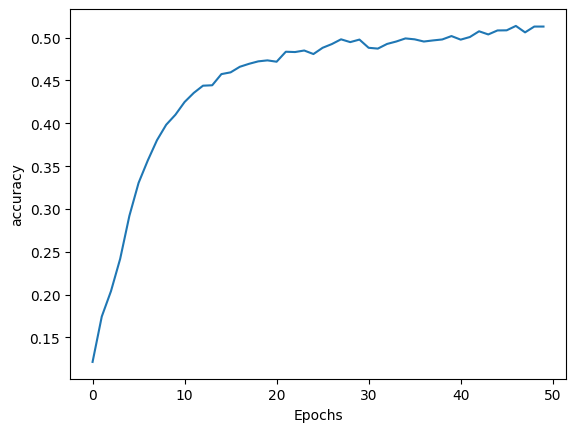

In [18]:
plot_graphs(history,'accuracy')

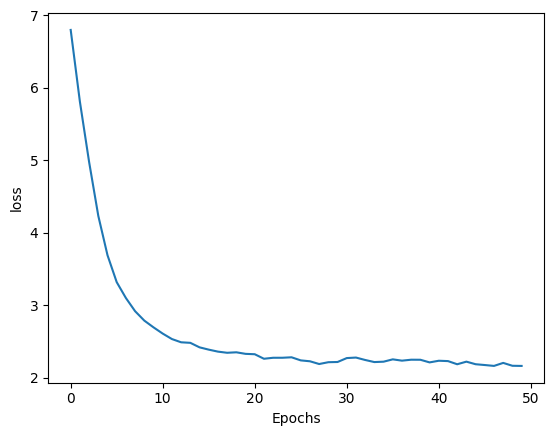

In [19]:
plot_graphs(history,'loss')

In [30]:
seed_text = "natural language"
next_words = 2

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list],maxlen=max_sequence_len-1,padding='pre')
    predicted = np.argmax(model.predict(token_list),axis=-1) # give highest index of 
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
        
print(seed_text)
        

1/1 [==============================] - 0s 19ms/step
natural language processing —


In [31]:
seed_text

'natural language processing —'

In [33]:
seed_text = "natural language"
next_words = 13

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list],maxlen=max_sequence_len-1,padding='pre')
    predicted = np.argmax(model.predict(token_list),axis=-1) # give highest index of 
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
        
print(seed_text)
        

1/1 [==============================] - 0s 17ms/step
natural language processing — event extraction and artificial intelligence and end to retention app r
